In [9]:
from preprocess_data import euler_output_to_rot_tensor, get_datasets, getSMPLXParams
import torch
from torch.utils.data import DataLoader

from euler_to_rot import euler_to_rotation_matrix_zyz_tensor
from metrics.losses import mpjpe_from_logits
from smplx_util import SMPLXHelper

train_data, test_data = get_datasets()
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=True)
sample_frame, sample_label, _ = next(iter(train_loader))
#print number of test dataset
SMPLX_Models_Path = '../smplx/models'
print('number of train images:', len(train_data))
print('number of test images:', len(test_data))

input_size = sample_frame.shape
# output_size = sample_label.shape
device = 'cuda'
print('input size:', input_size) # (batch_size, channels, height, width)
# print('output size:', output_size)

# Create a model
# move to cuda
smplx_helper = SMPLXHelper(SMPLX_Models_Path, device=device)
# mobilenet v3
model = torch.hub.load('pytorch/vision:v0.9.0', 'mobilenet_v3_small', pretrained=True)
model.classifier = torch.nn.Linear(576, 69)
model = model.to(device)
model.train()

# Train the model
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.MSELoss()
# criterion = torch.nn.L1Loss()

#start timing
import time

start = time.time()
last_time = start
history = {
    'train_loss': [],
    'validation_loss': []
}

num_batches_for_test = 100

for epoch in range(5):
    for i, v in enumerate(train_loader):
        model.train()
        frames, labels, _ = v
        frames = frames.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(frames)
        outputs_rot = euler_output_to_rot_tensor(outputs)
        loss = criterion(outputs_rot, labels)
        loss.backward()
        # loss = mpjpe_from_logits(outputs, labels, smplx_helper)
        # loss.backward()
        optimizer.step()
        if i % 10 == 0:
            print('Epoch: %d, Iteration: %d/%d, Loss: %f' % (epoch, i,len(train_loader), loss.item()))
        if i % 100 == 0:
            time_elapsed = time.time() - last_time
            print('Time elapsed: %d seconds' % time_elapsed)
            last_time = time.time()
            #estimate time remaining
            time_remaining = time_elapsed * (len(train_loader) - i)/100
            print('Estimated time remaining for epoch: %d seconds' % time_remaining)
        history['train_loss'].append(loss.item())
        if i%2000 == 0:
            #get MSE loss on test set
            model.eval()
            test_loader = DataLoader(test_data, batch_size=32, shuffle=True)
            with torch.no_grad():
                total_loss = 0
                for j, v in enumerate(test_loader):
                    frames, labels,_ = v
                    frames = frames.to(device)
                    labels = labels.to(device)
                    outputs = model(frames)
                    outputs_rot = euler_output_to_rot_tensor(outputs)
                    loss = criterion(outputs_rot, labels)
                    total_loss += loss.item()
                    if j > num_batches_for_test:
                        break
                print('Epoch: %d, iteration: %d, Test Loss: %f' % (epoch, i, total_loss/num_batches_for_test))
                history['validation_loss'].append(total_loss/num_batches_for_test)
            if i%10000 == 0 and i != 0:
                torch.save(model.state_dict(), f'checkpoints/mobilenetv3mse/mobilenet_v3_224x224_smplx_{epoch}_{i}.pth')
                #early stopping

# Save the model checkpoint
torch.save(model.state_dict(), 'checkpoints/mobilenetv3mse/mobilenet_v3_224x224_smplx.pth')

# Inference with the saved model
# load model mobilenet_v2_224x224.pth

number of train images: 1347793
number of test images: 149755
input size: torch.Size([32, 3, 224, 224])


Using cache found in C:\Users\DAQ/.cache\torch\hub\pytorch_vision_v0.9.0


Epoch: 0, Iteration: 0/42119, Loss: 0.152866
Time elapsed: 0 seconds
Estimated time remaining for epoch: 155 seconds
Epoch: 0, iteration: 0, Test Loss: 0.141324
Epoch: 0, Iteration: 10/42119, Loss: 0.047342
Epoch: 0, Iteration: 20/42119, Loss: 0.043221
Epoch: 0, Iteration: 30/42119, Loss: 0.030469
Epoch: 0, Iteration: 40/42119, Loss: 0.033650
Epoch: 0, Iteration: 50/42119, Loss: 0.037228
Epoch: 0, Iteration: 60/42119, Loss: 0.040734
Epoch: 0, Iteration: 70/42119, Loss: 0.027799
Epoch: 0, Iteration: 80/42119, Loss: 0.030084
Epoch: 0, Iteration: 90/42119, Loss: 0.028377
Epoch: 0, Iteration: 100/42119, Loss: 0.027012
Time elapsed: 29 seconds
Estimated time remaining for epoch: 12299 seconds
Epoch: 0, Iteration: 110/42119, Loss: 0.021290
Epoch: 0, Iteration: 120/42119, Loss: 0.018980
Epoch: 0, Iteration: 130/42119, Loss: 0.022682
Epoch: 0, Iteration: 140/42119, Loss: 0.025862
Epoch: 0, Iteration: 150/42119, Loss: 0.022237
Epoch: 0, Iteration: 160/42119, Loss: 0.026783
Epoch: 0, Iteration: 

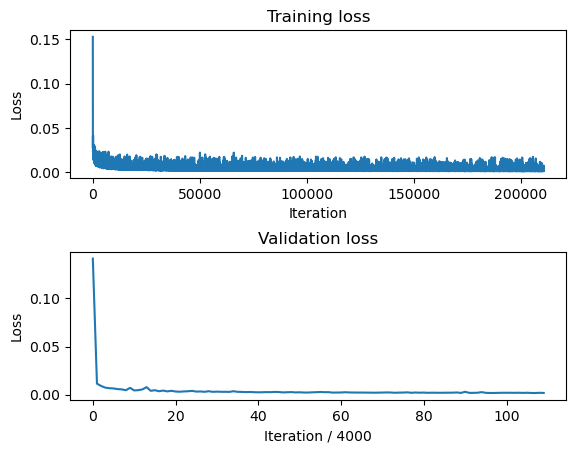

In [12]:
#plot train and test loss in two subplots
torch.save(model.state_dict(), 'checkpoints/mobilenetv3mse/mobilenet_v3_224x224_smplx.pth')

import matplotlib.pyplot as plt
plt.subplot(2,1,1)
plt.plot(history['train_loss'])
plt.title('Training loss')
#x axis
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.subplot(2,1,2)
#add space
plt.subplots_adjust(hspace=0.5)
plt.plot(history['validation_loss'])
plt.title('Validation loss')
#x axis
plt.xlabel('Iteration / 4000')
plt.ylabel('Loss')
plt.show()



In [11]:
import pickle as peter

with open('output/mobilenet_loss/mobilenetv3mse.pickle', 'wb') as f:
    peter.dump(history, f)